In [4]:
import torch 
from torch import nn, Tensor
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy as np

class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))

    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))

    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t= x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2)

def train_flow(x1_sampler, flow, steps=10000, batch_size=256):
    optimizer = torch.optim.Adam(flow.parameters(), lr=1e-2)
    loss_fn = nn.MSELoss()
    for _ in range(steps):
        x_1 = x1_sampler(batch_size)
        x_0 = torch.randn_like(x_1)
        t = torch.rand(len(x_1), 1)
        x_t = (1 - t) * x_0 + t * x_1
        dx_t = x_1 - x_0
        optimizer.zero_grad()
        loss_fn(flow(t=t, x_t=x_t), dx_t).backward()
        optimizer.step()

def visualize_flow(flow, title):
    x = torch.randn(300, 2)
    n_steps = 8
    fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
    time_steps = torch.linspace(0, 1.0, n_steps + 1)
    axes[0].scatter(x[:, 0], x[:, 1], s=10)
    axes[0].set_title(f't = {time_steps[0]:.2f}')
    axes[0].set_xlim(-6.0, 6.0)
    axes[0].set_ylim(-6.0, 6.0)
    for i in range(n_steps):
        x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
        axes[i + 1].scatter(x[:, 0].detach(), x[:, 1].detach(), s=10)
        axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')
    plt.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{title}.png')

def sample_scenario_1(n):
    return torch.tensor(np.random.multivariate_normal([4, 0], np.eye(2), size=n), dtype=torch.float32)

def sample_scenario_2(n):
    a = np.random.multivariate_normal([4, 2], np.eye(2), size=n//2)
    b = np.random.multivariate_normal([4, -2], np.eye(2), size=n//2)
    x1 = np.vstack([a, b])
    np.random.shuffle(x1)
    return torch.tensor(x1, dtype=torch.float32)

def sample_scenario_3(n):
    a = np.random.multivariate_normal([4, 2], np.eye(2), size=n//2)
    b = np.random.multivariate_normal([4, -2], np.eye(2), size=n//2)
    return torch.tensor(np.vstack([a, b]), dtype=torch.float32)

def sample_scenario_4(n):
    a = np.random.multivariate_normal([4, -2], np.eye(2), size=n//2)
    b = np.random.multivariate_normal([4, 2], np.eye(2), size=n//2)
    return torch.tensor(np.vstack([a, b]), dtype=torch.float32)


ModuleNotFoundError: No module named 'sklearn'

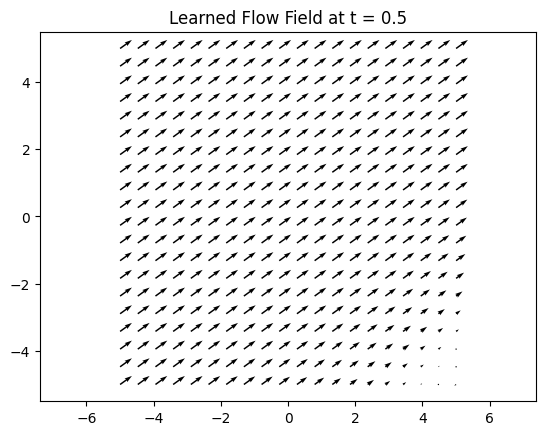

In [3]:
flow = Flow()
optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()
for _ in range(10000):
    x_1 = Tensor(make_moons(256, noise=0.05)[0])
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0

    optimizer.zero_grad()
    loss_fn(flow(t=t, x_t=x_t), dx_t).backward()
    optimizer.step()

x = torch.randn(300, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)
axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)
for i in range(n_steps):
    x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')
plt.tight_layout()
plt.show()
plt.savefig('gaussian_to_moon.png')



In [5]:

scenarios = [
    ("Scenario 1: Normal → Gaussian (left to right)", sample_scenario_1),
    ("Scenario 2: Normal → Random Gaussian Mix (upper+lower)", sample_scenario_2),
    ("Scenario 3: Normal → Matched Gaussian Pairing", sample_scenario_3),
    ("Scenario 4: Normal → Crossed Gaussian Pairing", sample_scenario_4),
]

for title, sampler in scenarios:
    flow = Flow()
    train_flow(sampler, flow)
    visualize_flow(flow, title)

NameError: name 'sample_scenario_1' is not defined